# Week 3 Challenge
### Title
Change point analysis to quantify the impact of African government policy interventions to slow the spread of COVID-19

### Contents
* Git repo installation
* Importing libraries and modules
* Data retrieval from Johns Hops University
* Data pre-processing and visualization
* Model creation (SIR model)
  > The SIR model is used because it can be used to gain better understanding of how the virus spreads within a community of variable populations in time.
* MCMC (Markov Chain Monte Carlo) sampling
* Plotting
  * Distributions
  * Timeseries

## Task 2


In [1]:
 !pip install git+https://github.com/Priesemann-Group/covid19_inference.git

  Cloning https://github.com/Priesemann-Group/covid19_inference.git to /tmp/pip-req-build-ga1htqmd
  Running command git clone -q https://github.com/Priesemann-Group/covid19_inference.git /tmp/pip-req-build-ga1htqmd
  Created wheel for covid19-inference: filename=covid19_inference-0.1.8a0-cp36-none-any.whl size=103637 sha256=4feca0f783493bb3936a78fe4762c55b79349f5cbfc8c503aed51c05e372b2b9
  Stored in directory: /tmp/pip-ephem-wheel-cache-vplsamxp/wheels/da/f1/e7/da56ba4fe019b70927b4bb10088f02f672b31b69fd54a6e613
Successfully built covid19-inference


In [2]:
#import the necessary library
from google.colab import files
import datetime
import time as time_module
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
import theano
import theano.tensor as tt
import pymc3 as pm
import pickle

In [3]:
#import the module!
try:
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append("../../")
    import covid19_inference as cov19

### Task 2.1
**Question a:** Downloading the COVID19 case data for South Africa


In [4]:
# Downloading the dataset
jhu = cov19.data_retrieval.JHU() 
jhu.download_all_available_data()

INFO     [covid19_inference.data_retrieval._JHU] Successfully downloaded new files.
INFO     [covid19_inference.data_retrieval._JHU] Local backup to ['/tmp/covid19_data/Jhu_confirmed.csv.gz', '/tmp/covid19_data/Jhu_deaths.csv.gz', '/tmp/covid19_data/Jhu_recovered.csv.gz'] successful.


INFO     [numexpr.utils] NumExpr defaulting to 2 threads.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

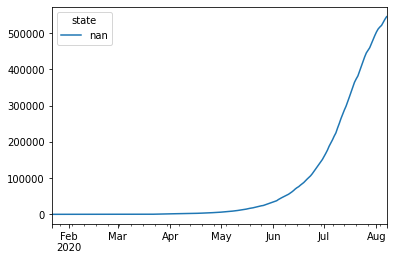

In [5]:
#Retrieving the data for south africa
dfsouth= jhu.confirmed['South Africa']

#visualizing the data
dfsouth.plot()

#saving the figure
plt.savefig('sadata.png')
files.download('sadata.png')

In [6]:
#changing the column name to 'value'
dfsouth.columns = ['value']
dfsouth

,value
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0
...,...
2020-08-03,516862
2020-08-04,521318
2020-08-05,529877
2020-08-06,538184


**Question b:** Pre-processing the downloaded data

In [7]:
"""pre-processing the data to make the starting date of the data 
is when the number of covid19 cases reaches 100"""
dfsouth = dfsouth[dfsouth['value']>100]
dfsouth

,value
2020-03-18,116
2020-03-19,150
2020-03-20,202
2020-03-21,240
2020-03-22,274
...,...
2020-08-03,516862
2020-08-04,521318
2020-08-05,529877
2020-08-06,538184


**Question c:** Checking for NaN values

In [8]:
#checking for null values
dfsouth.isnull().sum()

value    0
dtype: int64

In [9]:
#setting the start date and end date
bd = datetime.datetime(2020, 3, 18)  # For the date filter
ed = datetime.datetime.now()

#ed = datetime.datetime(2020, 8, 5)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

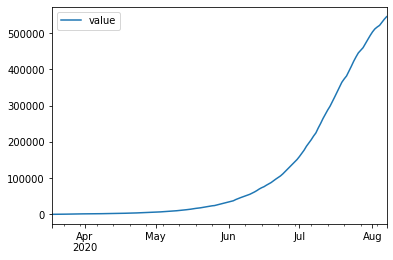

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

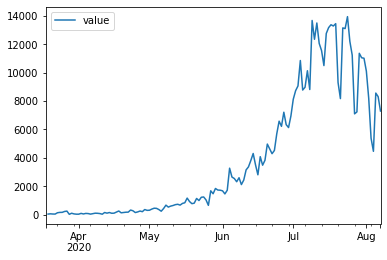

In [10]:
#getting the total cases and new cases
total_cases_obs = dfsouth
total_cases_obs.plot() #visualization
#saving the figure
plt.savefig('total.png')
files.download('total.png')
plt.show()

new_cases_obs = dfsouth - dfsouth.shift(1)
new_cases_obs.plot() #visualization
#saving the figure
plt.savefig('new.png')
files.download('new.png')
plt.show()

**Question d:** Splitting the data into train and test set  
Train data - 18th March to 25th July
Test data - 26th July to now

In [11]:
dfsouth.iloc[129]

value    434200
Name: 2020-07-25 00:00:00, dtype: int64

In [12]:
#using slicing to split the data
train_set = dfsouth.iloc[:130]
test_set = dfsouth.iloc[130:]

In [13]:
#displaying the train and test data
print("Train Set\n-------------------\n",train_set.tail(),"\n")
print("Test Set\n--------------------\n",test_set)

Train Set
-------------------
              value
2020-07-21  381798
2020-07-22  394948
2020-07-23  408052
2020-07-24  421996
2020-07-25  434200 

Test Set
--------------------
              value
2020-07-26  445433
2020-07-27  452529
2020-07-28  459761
2020-07-29  471123
2020-07-30  482169
2020-07-31  493183
2020-08-01  503290
2020-08-02  511485
2020-08-03  516862
2020-08-04  521318
2020-08-05  529877
2020-08-06  538184
2020-08-07  545476


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

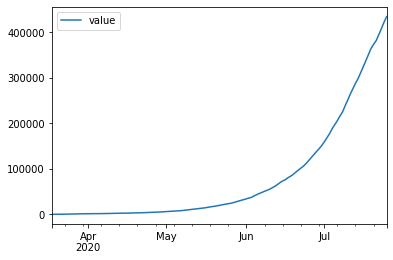

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

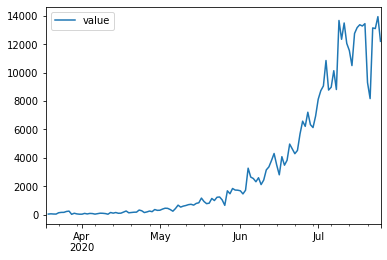

In [14]:
#getting the new total cases and new cases from the train data
total_cases_obs = train_set
total_cases_obs.plot() #visualization
#saving the figure
plt.savefig('totalnew.png')
files.download('totalnew.png')
plt.show()

new_cases_obs = train_set - train_set.shift(1)
new_cases_obs.plot() #visualization
#saving the figure
plt.savefig('new2.png')
files.download('new2.png')
plt.show()

In [15]:
#changing to a series
total_cases_obs = total_cases_obs.T
total_cases_obs = total_cases_obs.iloc[0,:]
type(total_cases_obs)

pandas.core.series.Series

In [16]:
#changing to a series
new_cases_obs = new_cases_obs.T
new_cases_obs = new_cases_obs.iloc[0,:]
type(new_cases_obs)

pandas.core.series.Series

In [17]:
#checking for null values
new_cases_obs.isnull().sum()

1

In [18]:
#filling nan value with 0
new_cases_obs = new_cases_obs.fillna(0)
new_cases_obs

2020-03-18        0.0
2020-03-19       34.0
2020-03-20       52.0
2020-03-21       38.0
2020-03-22       34.0
               ...   
2020-07-21     8170.0
2020-07-22    13150.0
2020-07-23    13104.0
2020-07-24    13944.0
2020-07-25    12204.0
Name: value, Length: 130, dtype: float64

**Question e:** Creating the model

In [19]:
diff_data_sim = 16  # should be significantly larger than the expected delay, in
# order to always fit the same number of data points.
num_days_forecast = 16 #from 26th july to 10th august

Changepoints refers to the dates when government introduced non-pharmaceutical policies in response to curbing the spread of the virus within the country. The major changepoints are:

* March 26, 2020 - 21 days lockdown was enforced.
* July 12, 2020 - Curfew, alcohol ban, and mandatory mask wearing was introduced. 


In [20]:
# We set the priors for the changepoints here
#prior_date_mild_dist_begin = datetime.datetime(2020, 3, 9)
prior_date_strong_dist_begin = datetime.datetime(2020, 3, 26)
prior_date_contact_ban_begin = datetime.datetime(2020, 7, 12)

In [21]:
change_points = [
    dict(
        pr_mean_date_transient=prior_date_strong_dist_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_contact_ban_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8 / 2,
        pr_sigma_lambda=1,
    ),
]

Next, we create the model! There are default values for most of the function arguments, but we will try to explicitly set all kwargs for the sake of this example.

In [22]:
params_model = dict(
    new_cases_obs=new_cases_obs[:],
    data_begin=bd,
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=4e6,
)
# Median of the prior for the delay in case reporting, we assume 10 days
pr_delay = 10

In [23]:
with cov19.model.Cov19Model(**params_model) as this_model:
    # Create the an array of the time dependent infection rate lambda
    lambda_t_log = cov19.model.lambda_t_with_sigmoids(
        pr_median_lambda_0=0.4,
        pr_sigma_lambda_0=0.5,
        change_points_list=change_points,  # The change point priors we constructed earlier
        name_lambda_t="lambda_t",  # Name for the variable in the trace (see later)
    )

    # set prior distribution for the recovery rate
    mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

    # This builds a decorrelated prior for I_begin for faster inference.
    # It is not necessary to use it, one can simply remove it and use the default argument
    # for pr_I_begin in cov19.SIR
    prior_I = cov19.model.uncorrelated_prior_I(
        lambda_t_log=lambda_t_log,
        mu=mu,
        pr_median_delay=pr_delay,
        name_I_begin="I_begin",
        name_I_begin_ratio_log="I_begin_ratio_log",
        pr_sigma_I_begin=2,
        n_data_points_used=5,
    )

    # Use lambda_t_log and mu to run the SIR model
    new_cases = cov19.model.SIR(
        lambda_t_log=lambda_t_log,
        mu=mu,
        name_new_I_t="new_I_t",
        name_I_t="I_t",
        name_I_begin="I_begin",
        pr_I_begin=prior_I,
    )

    # Delay the cases by a lognormal reporting delay
    new_cases = cov19.model.delay_cases(
        cases=new_cases,
        name_cases="delayed_cases",
        name_delay="delay",
        name_width="delay-width",
        pr_mean_of_median=pr_delay,
        pr_sigma_of_median=0.2,
        pr_median_of_width=0.3,
    )

    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = cov19.model.week_modulation(
        cases=new_cases,
        name_cases="new_cases",
        name_weekend_factor="weekend_factor",
        name_offset_modulation="offset_modulation",
        week_modulation_type="abs_sine",
        pr_mean_weekend_factor=0.3,
        pr_sigma_weekend_factor=0.5,
        weekend_days=(6, 7),
    )

    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.model.student_t_likelihood(new_cases)

INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying case

### MCMC Sampling
After the model is built, it is sampled using an MCMC sampler. The number of parallel runs can be set with the argument cores=. The sampling can take a long time.

In [24]:
trace = pm.sample(model=this_model, tune=200, draws=250, 
                  cores=8, init="advi+adapt_diag")

#saving the model in a pickle
pickle_out = open("model.pickle","wb")
pickle.dump(this_model, pickle_out)
files.download('model.pickle')
pickle_out.close()

pickle_out2 = open("model2.pickle","wb")
pickle.dump(trace, pickle_out2)
files.download('model2.pickle')
pickle_out2.close()

Only 250 samples in chain.
WARNING  [pymc3] Only 250 samples in chain.
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING  [theano.tensor.blas] We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING  [theano.tensor.blas] We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Average Loss = 958.19:  21%

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Plotting
#### Distributions

Possible varnames are :
['lambda_0_log_', 'lambda_1_log_', 'lambda_2_log_', 'transient_day_1', 'transient_day_2', 'transient_len_1_log_', 'transient_len_2_log_', 'mu', 'I_begin_ratio_log', 'delay_log', 'weekend_factor_log', 'offset_modulation_rad_circular__', 'sigma_obs']


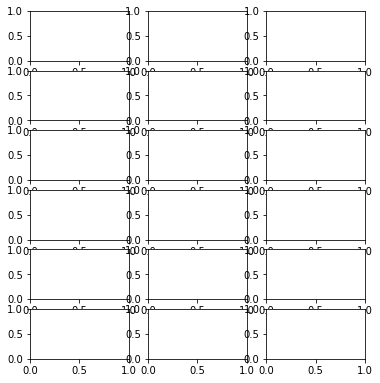

In [25]:
fig, axes = plt.subplots(6, 3, figsize=(6, 6.4))
varnames = this_model.untransformed_freeRVs
print("Possible varnames are :")
print(varnames)

In [26]:
for i, key in enumerate(
    # left column
    ["weekend_factor", "mu", "lambda_0", "lambda_1", "lambda_2"]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i, 0])

In [27]:
for i, key in enumerate(
    # mid column
    [
        "offset_modulation",
        "sigma_obs",
        "I_begin",
        "transient_day_1",
        "transient_day_2",
    ]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i, 1])

In [28]:
for i, key in enumerate(
    # right column
    ["delay", "transient_len_1", "transient_len_2",]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i + 2, 2])

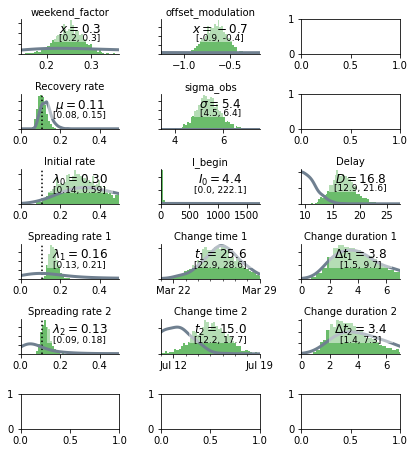

In [29]:
fig.tight_layout()
fig #To print in jupyter notebook

### Time Series
Time series overview, for now needs an offset variable to get cummulative cases.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

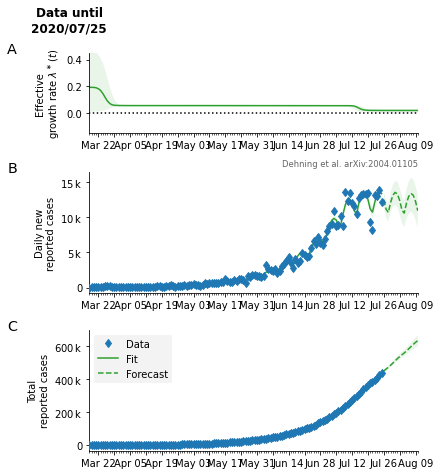

In [30]:
fig, axes = cov19.plot.timeseries_overview(this_model, trace, 
                                           offset=total_cases_obs[0])
#saving the figure
plt.savefig('timeseries.png')
files.download('timeseries.png')